# Example Markowitz

## Empirical Forecast
### Example of backtest with Mean-Variance strategy with a simple empirical forecaster

In [1]:
using Pkg
Pkg.activate(@__DIR__)

  Activating project at `~/Workspace/PortfolioOpt/examples/mean_variance_po`


In [2]:
using COSMO
using Distributions
using Plots
using Plots.PlotMeasures
using PortfolioOpt
using PortfolioOpt.TestUtils

In [ ]:
# Read Prices
prices = get_test_data();
numD, numA = size(prices) # A: Assets    D: Days

# Calculating returns
returns_series = percentchange(prices);

day2float(day) = float(parse(Int, (replace(replace(string(day), " day" => ""), "s" => ""))))

plot_dates = timestamp(returns_series)[1:120];
train_dates = plot_dates[1:99];
test_dates = plot_dates[100:end];
all_days = plot_dates - minimum(plot_dates);
x_plot = day2float.(all_days);
x_train = x_plot[1:99];
x_test = x_plot[100:end];
y_train = values(returns_series[plot_dates[1:99]]);
y_test = values(returns_series[plot_dates[100:end]]);

# normalise the observations
ymean = mean(y_train);
ystd = std(y_train);
y_train_norm = (y_train .- ymean) ./ ystd;

# Backtest Parameters
DEFAULT_SOLVER = optimizer_with_attributes(
    COSMO.Optimizer, "verbose" => false, "max_iter" => 900000
)

date_range = timestamp(returns_series)[100:end];

# Backtest
backtest_results = Dict()
backtest_results["EP_markowitz_limit_var"], _ = sequential_backtest_market(
    VolumeMarketHistory(returns_series), date_range,
) do market, past_returns, ext

    # println("backtest day ", ext[:date])

    # Parameters
    max_std = 0.003 / market_budget(market)
    k_back = 60

    # Prep
    numD, numA = size(past_returns)
    returns = values(past_returns)

    # Forecast
    Σ, r̄ = mean_variance(returns[(end - k_back):end, :])
    d = MvNormal(r̄, Σ)

    # PO Formulation
    formulation = PortfolioFormulation(MAX_SENSE,
        ObjectiveTerm(ExpectedReturn(d)),
        RiskConstraint(SqrtVariance(d), LessThan(max_std)),
    )

    pointers = change_bids!(market, formulation, DEFAULT_SOLVER)
    return pointers
end;

## GP Forecast
### First we train the forecaster offline
Note that the chosen kernel is not well suited to this task, so this is not really a fair comparison

In [ ]:
# Load our GP-related packages.
using AbstractGPs
using KernelFunctions
using LinearMixingModels
using LinearAlgebra
using KernelFunctions: MOInputIsotopicByOutputs
using Optim # Standard optimisation algorithms.
using ParameterHandling # Helper functionality for dealing with model parameters.
# using Zygote # Algorithmic Differentiation
using ForwardDiff
using ParameterHandling: flatten
using PrincipledRisk
using FactorisedDistributions
using Flux


# Prep forecaster
num_latent_variables = 3
U, S, _ = svd(rand(numA, num_latent_variables));

period = 7.0  # assume weekly periodicity
len_init = period * 5.0
period_len_init = 0.5

flat_initial_params, unflatten = flatten((
    len = positive(len_init),
    period_len = positive(period_len_init),  # bound this param to prevent numerical errors
    var_noise = positive(0.1),
    H = Matrix(Orthogonal(U, Diagonal(S)))
))

# Construct a function to unpack flattened parameters and pull out the raw values.
unpack = ParameterHandling.value ∘ unflatten
params = unpack(flat_initial_params)

# TODO: our desired kernel doesn't work with LinearMixingModels, raise an issue
function build_gp(θ)
    k_maper = compose(MAPeriodicKernel(; r=[θ.period_len]), ScaleTransform(1 / period))
    k_rq = with_lengthscale(RationalQuadraticKernel(), θ.len)
    sogp = GP(k_rq * k_maper)
    latent_gp = independent_mogp([sogp for _ in 1:num_latent_variables]);
    return ILMM(latent_gp, θ.H);
end

x_train_gp = MOInputIsotopicByOutputs(x_train, numA);
y_train_gp = vec(y_train_norm);

function objective(θ)
    ilmm = build_gp(θ)
    return -logpdf(ilmm(x_train_gp, θ.var_noise), y_train_gp)
end

objective(params)

# Optimise using Optim.
training_results = Optim.optimize(
    objective ∘ unpack,
    # θ -> only(Zygote.gradient(objective ∘ unpack, θ)),
    θ -> ForwardDiff.gradient(objective ∘ unpack, θ),
    flat_initial_params,
    BFGS(
        alphaguess = Optim.LineSearches.InitialStatic(scaled=true),
        linesearch = Optim.LineSearches.BackTracking(),
    ),
    Optim.Options(show_trace = true, iterations=50);
    inplace=false,
)

# Extracting the final values of the parameters.
# Should be close to truth.
final_params = unpack(training_results.minimizer);

# Test Predict
x_plot_gp = MOInputIsotopicByOutputs(x_plot, numA);
# x_test_gp = MOInputIsotopicByOutputs(x_test, numA);

ilmm = build_gp(final_params);
# TODO: it is unclear whether var_noise should be included at both steps here
ilmmx = ilmm(x_train_gp, final_params.var_noise);
p_ilmmx = posterior(ilmmx, y_train_gp);
p_i = p_ilmmx(x_plot_gp, final_params.var_noise);  # TODO: check whether obs noise needs to be injected here
marg_pi = marginals(p_i);

# un-normalise the predictions
marg_pi_unnorm = marg_pi .* ystd .+ ymean;

In [ ]:
xmin = minimum(plot_dates);
xmax = maximum(plot_dates);
num_plot = length(plot_dates);
plt = Array{Any}(undef, numA);
for i=1:numA
    plt[i] = scatter(train_dates, y_train[:, i]; label = "Train Data $i", size=(900, 700), Title="Asset $i");
    plot!(plt[i], plot_dates, mean.(marg_pi_unnorm[num_plot*(i-1)+1:num_plot*(i)]); ribbon=std.(marg_pi_unnorm[num_plot*(i-1)+1:num_plot*(i)]), label = "Forecast $i", xlims=(xmin, xmax));
    scatter!(plt[i], test_dates, y_test[:, i]; label = "Test Data $i")
end
plot(plt..., size=(950, 600), xrotation = 15)

### Now we run a backtest

In [ ]:
backtest_results["GP_markowitz_limit_var"], _ = sequential_backtest_market(
    VolumeMarketHistory(returns_series), date_range,
) do market, past_returns, ext

    # println("backtest day ", ext[:date])

    # Parameters
    max_std = 0.003 / market_budget(market)
    k_back = 60

    # Prep
    numD, numA = size(past_returns)

    # Forecast
    dates_for_training = timestamp(past_returns)[end-k_back:end]
    days_for_training = dates_for_training - minimum(dates_for_training)
    day_for_test = ext[:date] - minimum(dates_for_training)
    x_train_gp = MOInputIsotopicByOutputs(day2float.(days_for_training), numA)
    x_test_gp = MOInputIsotopicByOutputs([day2float(day_for_test)], numA)
    y_train = values(past_returns[dates_for_training])
    y_train_gp = vec((y_train .- ymean) ./ ystd)  # normalise the observations

    ilmm = build_gp(final_params)
    # TODO: it is unclear whether var_noise should be included at both steps here
    ilmmx = ilmm(x_train_gp, final_params.var_noise)
    p_ilmmx = posterior(ilmmx, y_train_gp)
    d = p_ilmmx(x_test_gp, final_params.var_noise)
    # un-normalise the predictions
    r̄ = mean(d) .* ystd .+ ymean
    Σ = cov(d) .* ystd^2
    d = MvNormal(r̄, Σ)

    # # PO Formulation
    formulation = PortfolioFormulation(MAX_SENSE,
        ObjectiveTerm(ExpectedReturn(d)),
        RiskConstraint(SqrtVariance(d), LessThan(max_std)),
    )

    pointers = change_bids!(market, formulation, DEFAULT_SOLVER)
    return pointers
end;

## GPRN Forecast
### First we train the forecaster offline

In [ ]:
num_latents = num_latent_variables + numA * num_latent_variables;
num_weights = num_latents-num_latent_variables;

# define the likelihood model:
likelihood(θ) = GPRNLikelihood(numA, num_latent_variables, θ.output_noise_scale, θ.latent_noise_scale)

# TODO: how should we initialise?
len_latent_init = period * 5.0
len_weight_init = period * 10.0  # the mixing weights should vary more slowly
period_len_latent_init = 0.5
period_len_weight_init = 2.0

θ_latents = (;  # hyperparameters for the GP prior latent factors
    len=positive(len_latent_init),
    period_len=positive(period_len_latent_init),
);

θ_weights = (;  # hyperparameters for the GP prior weight factors
    len=positive(len_weight_init),
    period_len=positive(period_len_weight_init),
);

θ_lik = (;  # hyperparameters for the likelihood model
    output_noise_scale=positive.(0.1ones(numA)),
    latent_noise_scale=positive.(0.25ones(num_latent_variables)),
);

θ_init = (;  # all hyperparameters
    factors = vcat(
        repeat([θ_latents], num_latent_variables),
        repeat([θ_weights], num_weights),
    ),
    lik = θ_lik
);


function kernel(θ)
    k_maper = compose(MAPeriodicKernel(; r=[θ.period_len]), ScaleTransform(1 / period))
    k_rq = with_lengthscale(RationalQuadraticKernel(), θ.len)
    return k_rq * k_maper
end

gp_model = UnevaluatedLatentFactorisedGP(
    repeat([UnevaluatedGP(kernel)], num_latents),
    likelihood
)


function hyperprior(θ)
    """ a Gaussian prior over the kernel lengthscales """
    lens = map(f -> f.len, θ.factors)
    period_lens = map(f -> f.period_len, θ.factors)
    lprior = MvNormal(
        vcat(len_latent_init*ones(num_latent_variables), len_weight_init*ones(num_weights)),
        Diagonal(vcat(20.0ones(num_latent_variables), 40.0ones(num_weights)))
        )
    plprior = MvNormal(
        vcat(period_len_latent_init*ones(num_latent_variables), period_len_weight_init*ones(num_weights)),
        Diagonal(vcat(1.0ones(num_latent_variables), 1.0ones(num_weights)))
        )
    return logpdf(lprior, lens) + logpdf(plprior, period_lens)
end

y_train_gprn = RowVecs(y_train_norm);

println("training model...")
lr_newton = 0.3;
lr_adam = 0.05;
num_iters = 50;
opt = ADAM(lr_adam);
cubature = Unscented3rdOrder(num_latents);
post, θ_opt = train(
    x_train,
    y_train_gprn,
    gp_model,
    θ_init,
    num_iters,
    lr_newton,
    opt,
    cubature,
    hyperprior
);
# println(ParameterHandling.value(θ))

marginal_posterior_predictive = predict_in_data_space(post, x_plot, cubature);
marg_mean = vecvec_to_matrix(mean.(marginal_posterior_predictive));
marg_std = vecvec_to_matrix((diag.(cov.(marginal_posterior_predictive)))) .^ 0.5;

# un-normalise the predictions
marg_mean_unnorm = marg_mean .* ystd .+ ymean;
marg_std_unnorm = marg_std .* ystd;

In [ ]:
plt = Array{Any}(undef, numA);
for i=1:numA
    plt[i] = scatter(train_dates, y_train[:, i]; label = "Train Data $i", size=(900, 700), Title="Asset $i");
    plot!(plt[i], plot_dates, marg_mean_unnorm[:, i]; ribbon=marg_std_unnorm[:, i], label = "Forecast $i", xlims=(xmin, xmax));
    scatter!(plt[i], test_dates, y_test[:, i]; label = "Test Data $i")
end
plot(plt..., size=(950, 600), xrotation = 15)

### We can also measure the uncertainty in the noise covariance

In [ ]:
# function sample_noise_cov(p, latent_prediction::AbstractMvNormal, num_samps)
#     predsamp = rand.(repeat([latent_prediction], num_samps))
#     moments = conditional_moments.((p.prior.lik, ), predsamp)
#     secondmoment = map(m -> m[3], moments)
#     return secondmoment
# end

# sample_noise_cov(p, latent_prediction::AbstractVector{<:AbstractMvNormal}, num_samps) = sample_noise_cov.((p, ), latent_prediction, (num_samps, ))

function sample_cov(p, latent_prediction::AbstractMvNormal, num_samps)
    l = p.prior.lik
    predsamp = rand.(repeat([latent_prediction], num_samps))
    # the following is based on the specific form of the GPRNLikelihood from PrincipledRisk.jl
    F_cov = cov(latent_prediction)[1:l.latent_dim, 1:l.latent_dim] + Diagonal(l.latent_noise_scale)
    W_samp = map(p -> p[l.latent_dim+1:end] .+ l.additive_const, predsamp)  # sample the weights
    W_samp = reshape.(W_samp, l.output_dim, l.latent_dim)
    sample_cov = W_samp .* (F_cov, ) .* transpose.(W_samp) .+ (Diagonal(l.output_noise_scale), )
    return sample_cov
end

sample_cov(p, latent_prediction::AbstractVector{<:AbstractMvNormal}, num_samps) = sample_cov.((p, ), latent_prediction, (num_samps, ))


# measure the uncertainty in the noise covariance at a single test point
test_pred = predict_in_data_space(post, x_test[1:1], cubature);
testcov_unnorm = cov(only(test_pred)) .* ystd^2;
latent_predict = predict(post, x_test[1:1]);
s_cov = sample_cov(post, latent_predict, 5000);
s_cov_unnorm = s_cov .* ystd^2;
# cov_mean = mean.(s_cov_unnorm);
cov_std = std.(s_cov_unnorm);

Matisless(cov_1,cov_2) = minimum(eigvals(cov_2 .- cov_1))>=0
λ2 = (1:0.1:20)[findfirst((λ) -> all([Matisless(cov_aux, testcov_unnorm * λ) for cov_aux in s_cov_unnorm[1]]), 1:0.1:20)]
biggest_cov = testcov_unnorm * λ2

p1 = heatmap(testcov_unnorm, title="Predictive Covariance");
p2 = heatmap(only(cov_std), title="std of Predictive Covariance");
p3 = heatmap(biggest_cov, title="SDP UB of Predictive Covariance");
plot(p1, p2, p3, size=(900, 350))

### Now run a backtest with the GPRN forecaster
This involves re-fitting the variational parameters every time, so takes longer than the previous backtests

In [40]:
backtest_results["GPRN_markowitz_limit_var"], _ = sequential_backtest_market(
    VolumeMarketHistory(returns_series), date_range,
) do market, past_returns, ext

    # println("backtest day ", ext[:date])

    # Parameters
    max_std = 0.003 / market_budget(market)
    k_back = 60

    # Prep
    numD, numA = size(past_returns)

    # Forecast
    dates_for_training = timestamp(past_returns)[end-k_back:end]
    days_for_training = dates_for_training - minimum(dates_for_training)
    day_for_test = ext[:date] - minimum(dates_for_training)
    x_train_gprn = day2float.(days_for_training)
    x_test_gprn = [day2float(day_for_test)]
    y_train = values(past_returns[dates_for_training])
    y_train_gprn = RowVecs((y_train .- ymean) ./ ystd)  # normalise the observations

    # need to re-fit the variational parameters
    num_iters_backtest = 7
    opt_backtest = ADAM(0.0)  # don't change the hyperparameters
    post, θ_opt = train(
        x_train_gprn,
        y_train_gprn,
        gp_model,
        θ_init,
        num_iters_backtest,
        lr_newton,
        opt_backtest,
        cubature,
        hyperprior
    )

    pred = only(predict_in_data_space(post, x_test_gprn, cubature))
    # un-normalise the predictions
    r̄ = mean(pred) .* ystd .+ ymean
    Σ = cov(pred) .* ystd^2
    d = MvNormal(r̄, Σ)

    # PO Formulation
    formulation = PortfolioFormulation(MAX_SENSE,
        ObjectiveTerm(ExpectedReturn(d)),
        RiskConstraint(SqrtVariance(d), LessThan(max_std)),
    )

    pointers = change_bids!(market, formulation, DEFAULT_SOLVER)
    return pointers
end;

Computing...   1%|▍                                      |  ETA: 0:19:35

Computing...   1%|▌                                      |  ETA: 0:18:40

Computing...   2%|▊                                      |  ETA: 0:18:17

Computing...   2%|▉                                      |  ETA: 0:18:03

Computing...   3%|█▏                                     |  ETA: 0:18:01

Computing...   3%|█▎                                     |  ETA: 0:17:50

Computing...   4%|█▌                                     |  ETA: 0:17:38

Computing...   4%|█▋                                     |  ETA: 0:17:27

Computing...   5%|█▊                                     |  ETA: 0:17:16

Computing...   5%|██                                     |  ETA: 0:17:03

Computing...   6%|██▏                                    |  ETA: 0:16:52

Computing...   6%|██▍                                    |  ETA: 0:16:42

Computing...   6%|██▌                                    |  ETA: 0:16:36

Computing...   7%|██▊                                    |  ETA: 0:16:31

Computing...   7%|██▉                                    |  ETA: 0:16:26

Computing...   8%|███▏                                   |  ETA: 0:16:20

Computing...   8%|███▎                                   |  ETA: 0:16:13

Computing...   9%|███▍                                   |  ETA: 0:16:06

Computing...   9%|███▋                                   |  ETA: 0:15:59

Computing...  10%|███▊                                   |  ETA: 0:15:52

Computing...  10%|████                                   |  ETA: 0:15:44

Computing...  11%|████▏                                  |  ETA: 0:15:36

Computing...  11%|████▍                                  |  ETA: 0:15:29

Computing...  12%|████▌                                  |  ETA: 0:15:29

Computing...  12%|████▊                                  |  ETA: 0:15:21

Computing...  12%|████▉                                  |  ETA: 0:15:13

Computing...  13%|█████                                  |  ETA: 0:15:06

Computing...  13%|█████▎                                 |  ETA: 0:14:59

Computing...  14%|█████▍                                 |  ETA: 0:14:52

Computing...  14%|█████▋                                 |  ETA: 0:14:45

Computing...  15%|█████▊                                 |  ETA: 0:14:39

Computing...  15%|██████                                 |  ETA: 0:14:32

Computing...  16%|██████▏                                |  ETA: 0:14:26

Computing...  16%|██████▍                                |  ETA: 0:14:22

Computing...  17%|██████▌                                |  ETA: 0:14:16

Computing...  17%|██████▋                                |  ETA: 0:14:09

Computing...  18%|██████▉                                |  ETA: 0:14:04

Computing...  18%|███████                                |  ETA: 0:13:58

Computing...  19%|███████▎                               |  ETA: 0:13:53

Computing...  19%|███████▍                               |  ETA: 0:13:48

Computing...  19%|███████▋                               |  ETA: 0:13:42

Computing...  20%|███████▊                               |  ETA: 0:13:36

Computing...  20%|████████                               |  ETA: 0:13:31

Computing...  21%|████████▏                              |  ETA: 0:13:25

Computing...  21%|████████▎                              |  ETA: 0:13:20

Computing...  22%|████████▌                              |  ETA: 0:13:14

Computing...  22%|████████▋                              |  ETA: 0:13:09

Computing...  23%|████████▉                              |  ETA: 0:13:03

Computing...  23%|█████████                              |  ETA: 0:12:57

Computing...  24%|█████████▎                             |  ETA: 0:12:52

Computing...  24%|█████████▍                             |  ETA: 0:12:46

Computing...  25%|█████████▋                             |  ETA: 0:12:41

Computing...  25%|█████████▊                             |  ETA: 0:12:36

Computing...  25%|█████████▉                             |  ETA: 0:12:31

Computing...  26%|██████████▏                            |  ETA: 0:12:25

Computing...  26%|██████████▎                            |  ETA: 0:12:22

Computing...  27%|██████████▌                            |  ETA: 0:12:17

iter  1, NLML: 1117.2868 
iter  2, NLML: 900.0973 
iter  3, NLML: 842.1541 
iter  4, NLML: 822.5863 
iter  5, NLML: 813.7325 
iter  6, NLML: 808.9230 
iter  7, NLML: 806.2133 
iter  1, NLML: 1123.6149 
iter  2, NLML: 904.9475 
iter  3, NLML: 845.5904 
iter  4, NLML: 825.9491 
iter  5, NLML: 817.0696 
iter  6, NLML: 812.2320 
iter  7, NLML: 809.5217 
iter  1, NLML: 1147.9439 
iter  2, NLML: 950.5387 
iter  3, NLML: 901.1320 
iter  4, NLML: 879.1130 
iter  5, NLML: 865.9601 
iter  6, NLML: 859.4632 
iter  7, NLML: 856.7268 
iter  1, NLML: 1139.5234 
iter  2, NLML: 985.6672 
iter  3, NLML: 955.3409 
iter  4, NLML: 936.6770 
iter  5, NLML: 922.7813 
iter  6, NLML: 910.9671 
iter  7, NLML: 900.9914 
iter  1, NLML: 1140.4111 
iter  2, NLML: 989.6850 
iter  3, NLML: 957.5314 
iter  4, NLML: 936.0481 
iter  5, NLML: 918.3079 
iter  6, NLML: 904.1810 
iter  7, NLML: 895.0298 
iter  1, NLML: 1107.4087 
iter  2, NLML: 962.8439 
iter  3, NLML: 931.2575 
iter  4, NLML: 910.0262 
iter  5, NLML: 892.

Computing...  27%|██████████▋                            |  ETA: 0:12:13

Computing...  28%|██████████▉                            |  ETA: 0:12:08

Computing...  28%|███████████                            |  ETA: 0:12:02

Computing...  29%|███████████▎                           |  ETA: 0:11:57

Computing...  29%|███████████▍                           |  ETA: 0:11:52

Computing...  30%|███████████▌                           |  ETA: 0:11:47

Computing...  30%|███████████▊                           |  ETA: 0:11:42

Computing...  31%|███████████▉                           |  ETA: 0:11:37

Computing...  31%|████████████▏                          |  ETA: 0:11:31

Computing...  31%|████████████▎                          |  ETA: 0:11:26

Computing...  32%|████████████▌                          |  ETA: 0:11:21

Computing...  32%|████████████▋                          |  ETA: 0:11:16

Computing...  33%|████████████▉                          |  ETA: 0:11:11

Computing...  33%|█████████████                          |  ETA: 0:11:06

Computing...  34%|█████████████▏                         |  ETA: 0:11:01

Computing...  34%|█████████████▍                         |  ETA: 0:10:56

Computing...  35%|█████████████▌                         |  ETA: 0:10:51

Computing...  35%|█████████████▊                         |  ETA: 0:10:46

Computing...  36%|█████████████▉                         |  ETA: 0:10:41

Computing...  36%|██████████████▏                        |  ETA: 0:10:36

Computing...  37%|██████████████▎                        |  ETA: 0:10:31

Computing...  37%|██████████████▌                        |  ETA: 0:10:26

Computing...  38%|██████████████▋                        |  ETA: 0:10:21

Computing...  38%|██████████████▊                        |  ETA: 0:10:16

Computing...  38%|███████████████                        |  ETA: 0:10:12

Computing...  39%|███████████████▏                       |  ETA: 0:10:07

Computing...  39%|███████████████▍                       |  ETA: 0:10:02

Computing...  40%|███████████████▌                       |  ETA: 0:09:58

Computing...  40%|███████████████▊                       |  ETA: 0:09:53

Computing...  41%|███████████████▉                       |  ETA: 0:09:49

Computing...  41%|████████████████▏                      |  ETA: 0:09:44

Computing...  42%|████████████████▎                      |  ETA: 0:09:41

Computing...  42%|████████████████▍                      |  ETA: 0:09:36

Computing...  43%|████████████████▋                      |  ETA: 0:09:31

Computing...  43%|████████████████▊                      |  ETA: 0:09:27

Computing...  44%|█████████████████                      |  ETA: 0:09:22

Computing...  44%|█████████████████▏                     |  ETA: 0:09:18

Computing...  44%|█████████████████▍                     |  ETA: 0:09:13

Computing...  45%|█████████████████▌                     |  ETA: 0:09:08

Computing...  45%|█████████████████▊                     |  ETA: 0:09:04

Computing...  46%|█████████████████▉                     |  ETA: 0:08:59

Computing...  46%|██████████████████                     |  ETA: 0:08:54

Computing...  47%|██████████████████▎                    |  ETA: 0:08:49

Computing...  47%|██████████████████▍                    |  ETA: 0:08:45

Computing...  48%|██████████████████▋                    |  ETA: 0:08:40

Computing...  48%|██████████████████▊                    |  ETA: 0:08:35

Computing...  49%|███████████████████                    |  ETA: 0:08:30

Computing...  49%|███████████████████▏                   |  ETA: 0:08:26

Computing...  50%|███████████████████▍                   |  ETA: 0:08:21

Computing...  50%|███████████████████▌                   |  ETA: 0:08:16

Computing...  50%|███████████████████▋                   |  ETA: 0:08:11

Computing...  51%|███████████████████▉                   |  ETA: 0:08:07

Computing...  51%|████████████████████                   |  ETA: 0:08:02

Computing...  52%|████████████████████▎                  |  ETA: 0:07:57

Computing...  52%|████████████████████▍                  |  ETA: 0:07:53

Computing...  53%|████████████████████▋                  |  ETA: 0:07:48

Computing...  53%|████████████████████▊                  |  ETA: 0:07:43

Computing...  54%|█████████████████████                  |  ETA: 0:07:39

iter  5, NLML: 745.8453 
iter  6, NLML: 734.8885 
iter  7, NLML: 726.9336 
iter  1, NLML: 849.6367 
iter  2, NLML: 734.1701 
iter  3, NLML: 697.4060 
iter  4, NLML: 675.8023 
iter  5, NLML: 662.2826 
iter  6, NLML: 653.7109 
iter  7, NLML: 648.3030 
iter  1, NLML: 763.3911 
iter  2, NLML: 701.4447 
iter  3, NLML: 682.1033 
iter  4, NLML: 673.1506 
iter  5, NLML: 668.8187 
iter  6, NLML: 666.4259 
iter  7, NLML: 664.9160 
iter  1, NLML: 798.0414 
iter  2, NLML: 732.4561 
iter  3, NLML: 693.0985 
iter  4, NLML: 682.8768 
iter  5, NLML: 679.5527 
iter  6, NLML: 678.0289 
iter  7, NLML: 677.2196 
iter  1, NLML: 795.1214 
iter  2, NLML: 722.4040 
iter  3, NLML: 685.9965 
iter  4, NLML: 677.4099 
iter  5, NLML: 674.0646 
iter  6, NLML: 672.4528 
iter  7, NLML: 671.5899 
iter  1, NLML: 758.8151 
iter  2, NLML: 693.1573 
iter  3, NLML: 662.3783 
iter  4, NLML: 656.0526 
iter  5, NLML: 653.7852 
iter  6, NLML: 652.5835 
iter  7, NLML: 651.7969 
iter  1, NLML: 775.5241 
iter  2, NLML: 715.7625 


Computing...  54%|█████████████████████▏                 |  ETA: 0:07:34

Computing...  55%|█████████████████████▎                 |  ETA: 0:07:29

Computing...  55%|█████████████████████▌                 |  ETA: 0:07:25

Computing...  56%|█████████████████████▋                 |  ETA: 0:07:20

Computing...  56%|█████████████████████▉                 |  ETA: 0:07:15

Computing...  56%|██████████████████████                 |  ETA: 0:07:10

Computing...  57%|██████████████████████▎                |  ETA: 0:07:06

Computing...  57%|██████████████████████▍                |  ETA: 0:07:02

Computing...  58%|██████████████████████▋                |  ETA: 0:06:57

Computing...  58%|██████████████████████▊                |  ETA: 0:06:52

Computing...  59%|██████████████████████▉                |  ETA: 0:06:48

Computing...  59%|███████████████████████▏               |  ETA: 0:06:43

Computing...  60%|███████████████████████▎               |  ETA: 0:06:39

Computing...  60%|███████████████████████▌               |  ETA: 0:06:34

Computing...  61%|███████████████████████▋               |  ETA: 0:06:29

Computing...  61%|███████████████████████▉               |  ETA: 0:06:25

Computing...  62%|████████████████████████               |  ETA: 0:06:20

Computing...  62%|████████████████████████▎              |  ETA: 0:06:16

Computing...  62%|████████████████████████▍              |  ETA: 0:06:11

Computing...  63%|████████████████████████▌              |  ETA: 0:06:06

Computing...  63%|████████████████████████▊              |  ETA: 0:06:02

Computing...  64%|████████████████████████▉              |  ETA: 0:05:57

Computing...  64%|█████████████████████████▏             |  ETA: 0:05:52

Computing...  65%|█████████████████████████▎             |  ETA: 0:05:48

Computing...  65%|█████████████████████████▌             |  ETA: 0:05:43

Computing...  66%|█████████████████████████▋             |  ETA: 0:05:38

Computing...  66%|█████████████████████████▉             |  ETA: 0:05:34

Computing...  67%|██████████████████████████             |  ETA: 0:05:29

Computing...  67%|██████████████████████████▏            |  ETA: 0:05:25

Computing...  68%|██████████████████████████▍            |  ETA: 0:05:20

Computing...  68%|██████████████████████████▌            |  ETA: 0:05:15

Computing...  69%|██████████████████████████▊            |  ETA: 0:05:11

Computing...  69%|██████████████████████████▉            |  ETA: 0:05:06

Computing...  69%|███████████████████████████▏           |  ETA: 0:05:01

Computing...  70%|███████████████████████████▎           |  ETA: 0:04:57

Computing...  70%|███████████████████████████▌           |  ETA: 0:04:52

Computing...  71%|███████████████████████████▋           |  ETA: 0:04:48

Computing...  71%|███████████████████████████▊           |  ETA: 0:04:43

Computing...  72%|████████████████████████████           |  ETA: 0:04:38

Computing...  72%|████████████████████████████▏          |  ETA: 0:04:34

Computing...  73%|████████████████████████████▍          |  ETA: 0:04:29

Computing...  73%|████████████████████████████▌          |  ETA: 0:04:24

Computing...  74%|████████████████████████████▊          |  ETA: 0:04:20

Computing...  74%|████████████████████████████▉          |  ETA: 0:04:16

Computing...  75%|█████████████████████████████▏         |  ETA: 0:04:11

Computing...  75%|█████████████████████████████▎         |  ETA: 0:04:07

Computing...  75%|█████████████████████████████▍         |  ETA: 0:04:02

Computing...  76%|█████████████████████████████▋         |  ETA: 0:03:57

Computing...  76%|█████████████████████████████▊         |  ETA: 0:03:53

Computing...  77%|██████████████████████████████         |  ETA: 0:03:48

Computing...  77%|██████████████████████████████▏        |  ETA: 0:03:44

Computing...  78%|██████████████████████████████▍        |  ETA: 0:03:39

Computing...  78%|██████████████████████████████▌        |  ETA: 0:03:35

Computing...  79%|██████████████████████████████▊        |  ETA: 0:03:30

Computing...  79%|██████████████████████████████▉        |  ETA: 0:03:26

Computing...  80%|███████████████████████████████        |  ETA: 0:03:21

Computing...  80%|███████████████████████████████▎       |  ETA: 0:03:16

Computing...  81%|███████████████████████████████▍       |  ETA: 0:03:12

Computing...  81%|███████████████████████████████▋       |  ETA: 0:03:07

iter  1, NLML: 1125.1399 
iter  2, NLML: 904.9492 
iter  3, NLML: 843.1873 
iter  4, NLML: 817.6604 
iter  5, NLML: 805.8997 
iter  6, NLML: 799.6595 
iter  7, NLML: 795.8718 
iter  1, NLML: 1116.3663 
iter  2, NLML: 903.8334 
iter  3, NLML: 842.9287 
iter  4, NLML: 817.5292 
iter  5, NLML: 805.6774 
iter  6, NLML: 799.3046 
iter  7, NLML: 795.3832 
iter  1, NLML: 1165.4831 
iter  2, NLML: 929.8098 
iter  3, NLML: 856.6266 
iter  4, NLML: 825.6952 
iter  5, NLML: 810.9573 
iter  6, NLML: 802.9000 
iter  7, NLML: 798.0595 
iter  1, NLML: 1202.6686 
iter  2, NLML: 940.6409 
iter  3, NLML: 857.7441 
iter  4, NLML: 825.3414 
iter  5, NLML: 810.6388 
iter  6, NLML: 802.8473 
iter  7, NLML: 798.2941 
iter  1, NLML: 1202.5222 
iter  2, NLML: 936.7761 
iter  3, NLML: 849.5551 
iter  4, NLML: 813.7217 
iter  5, NLML: 797.9285 
iter  6, NLML: 789.9114 
iter  7, NLML: 785.4278 
iter  1, NLML: 1222.5386 
iter  2, NLML: 931.9723 
iter  3, NLML: 827.9822 
iter  4, NLML: 784.2082 
iter  5, NLML: 765.

Computing...  81%|███████████████████████████████▊       |  ETA: 0:03:03

Computing...  82%|████████████████████████████████       |  ETA: 0:02:58

Computing...  82%|████████████████████████████████▏      |  ETA: 0:02:54

Computing...  83%|████████████████████████████████▍      |  ETA: 0:02:49

Computing...  83%|████████████████████████████████▌      |  ETA: 0:02:44

Computing...  84%|████████████████████████████████▋      |  ETA: 0:02:40

Computing...  84%|████████████████████████████████▉      |  ETA: 0:02:35

Computing...  85%|█████████████████████████████████      |  ETA: 0:02:31

Computing...  85%|█████████████████████████████████▎     |  ETA: 0:02:26

Computing...  86%|█████████████████████████████████▍     |  ETA: 0:02:21

Computing...  86%|█████████████████████████████████▋     |  ETA: 0:02:17

Computing...  87%|█████████████████████████████████▊     |  ETA: 0:02:12

Computing...  87%|██████████████████████████████████     |  ETA: 0:02:08

Computing...  88%|██████████████████████████████████▏    |  ETA: 0:02:03

Computing...  88%|██████████████████████████████████▎    |  ETA: 0:01:59

Computing...  88%|██████████████████████████████████▌    |  ETA: 0:01:54

Computing...  89%|██████████████████████████████████▋    |  ETA: 0:01:49

Computing...  89%|██████████████████████████████████▉    |  ETA: 0:01:45

Computing...  90%|███████████████████████████████████    |  ETA: 0:01:40

Computing...  90%|███████████████████████████████████▎   |  ETA: 0:01:36

Computing...  91%|███████████████████████████████████▍   |  ETA: 0:01:31

Computing...  91%|███████████████████████████████████▋   |  ETA: 0:01:27

Computing...  92%|███████████████████████████████████▊   |  ETA: 0:01:22

Computing...  92%|███████████████████████████████████▉   |  ETA: 0:01:18

Computing...  93%|████████████████████████████████████▏  |  ETA: 0:01:13

Computing...  93%|████████████████████████████████████▎  |  ETA: 0:01:08

Computing...  94%|████████████████████████████████████▌  |  ETA: 0:01:04

Computing...  94%|████████████████████████████████████▋  |  ETA: 0:00:59

Computing...  94%|████████████████████████████████████▉  |  ETA: 0:00:55

Computing...  95%|█████████████████████████████████████  |  ETA: 0:00:50

Computing...  95%|█████████████████████████████████████▎ |  ETA: 0:00:46

Computing...  96%|█████████████████████████████████████▍ |  ETA: 0:00:41

Computing...  96%|█████████████████████████████████████▌ |  ETA: 0:00:36

Computing...  97%|█████████████████████████████████████▊ |  ETA: 0:00:32

Computing...  97%|█████████████████████████████████████▉ |  ETA: 0:00:27

Computing...  98%|██████████████████████████████████████▏|  ETA: 0:00:23

Computing...  98%|██████████████████████████████████████▎|  ETA: 0:00:18

Computing...  99%|██████████████████████████████████████▌|  ETA: 0:00:14

Computing...  99%|██████████████████████████████████████▋|  ETA: 0:00:09

Computing... 100%|██████████████████████████████████████▉|  ETA: 0:00:05

Computing... 100%|███████████████████████████████████████| Time: 0:16:25


iter  5, NLML: 530.5345 
iter  6, NLML: 529.1260 
iter  7, NLML: 527.9545 
iter  1, NLML: 596.1605 
iter  2, NLML: 549.6709 
iter  3, NLML: 539.5786 
iter  4, NLML: 536.2715 
iter  5, NLML: 534.3388 
iter  6, NLML: 532.8773 
iter  7, NLML: 531.6654 
iter  1, NLML: 592.5131 
iter  2, NLML: 545.1602 
iter  3, NLML: 535.0438 
iter  4, NLML: 531.7808 
iter  5, NLML: 529.9053 
iter  6, NLML: 528.5077 
iter  7, NLML: 527.3582 
iter  1, NLML: 579.3577 
iter  2, NLML: 533.9982 
iter  3, NLML: 524.5073 
iter  4, NLML: 521.3372 
iter  5, NLML: 519.3112 
iter  6, NLML: 517.6703 
iter  7, NLML: 516.2417 
iter  1, NLML: 584.3903 
iter  2, NLML: 537.0958 
iter  3, NLML: 527.1018 
iter  4, NLML: 523.7581 
iter  5, NLML: 521.6634 
iter  6, NLML: 519.9792 
iter  7, NLML: 518.5250 
iter  1, NLML: 596.1149 
iter  2, NLML: 542.4778 
iter  3, NLML: 528.9352 
iter  4, NLML: 524.4055 
iter  5, NLML: 521.9315 
iter  6, NLML: 520.1095 
iter  7, NLML: 518.6121 
iter  1, NLML: 555.9907 
iter  2, NLML: 524.1557 


In [43]:
backtest_results["GPRN_delage"], _ = sequential_backtest_market(
    VolumeMarketHistory(returns_series), date_range,
) do market, past_returns, ext

    # println("backtest day ", ext[:date])

    # Parameters
    max_std = 0.003 / market_budget(market)
    k_back = 60
    num_samples_cov = 500

    # Prep
    numD, numA = size(past_returns)

    # Forecast
    dates_for_training = timestamp(past_returns)[end-k_back:end]
    days_for_training = dates_for_training - minimum(dates_for_training)
    day_for_test = ext[:date] - minimum(dates_for_training)
    x_train_gprn = day2float.(days_for_training)
    x_test_gprn = [day2float(day_for_test)]
    y_train = values(past_returns[dates_for_training])
    y_train_gprn = RowVecs((y_train .- ymean) ./ ystd)  # normalise the observations

    # need to re-fit the variational parameters
    num_iters_backtest = 7
    opt_backtest = ADAM(0.0)  # don't change the hyperparameters
    post, θ_opt = train(
        x_train_gprn,
        y_train_gprn,
        gp_model,
        θ_init,
        num_iters_backtest,
        lr_newton,
        opt_backtest,
        cubature,
        hyperprior
    )

    pred = only(predict_in_data_space(post, x_test_gprn, cubature))
    latent_predict = predict(post, x_test_gprn);
    s_cov = sample_cov(post, latent_predict, num_samples_cov);

    # un-normalise the predictions
    r̄ = mean(pred) .* ystd .+ ymean
    Σ = cov(pred) .* ystd^2
    s_cov_unnorm = s_cov .* ystd^2;
    d = MvNormal(r̄, Σ)

    λ2 = (1:0.1:20)[findfirst((λ) -> all([Matisless(cov_aux, Σ * λ) for cov_aux in s_cov_unnorm[1]]), 1:0.1:20)]

    # PO Formulation
    formulation = PortfolioFormulation(MAX_SENSE,
        ObjectiveTerm(ExpectedUtility(MomentUncertainty(d, 0.005, λ2), 
            PieceWiseUtility(
                [1.0], [0.0]
            ),
            WorstCase
        )),
        RiskConstraint(SqrtVariance(d), LessThan(max_std)),
    )

    pointers = change_bids!(market, formulation, DEFAULT_SOLVER)
    return pointers
end;

Computing...   1%|▍                                      |  ETA: 0:17:22

Computing...   1%|▌                                      |  ETA: 0:18:08

Computing...   2%|▊                                      |  ETA: 0:17:48

Computing...   2%|▉                                      |  ETA: 0:17:34

Computing...   3%|█▏                                     |  ETA: 0:17:25

Computing...   3%|█▎                                     |  ETA: 0:17:12

┌ Warning: Did not find an optimal solution: status=ITERATION_LIMIT
└ @ PortfolioOpt /Users/andrewrosemberg/Workspace/PortfolioOpt/src/VolumeMarket.jl:113
Computing...   4%|█▌                                     |  ETA: 0:29:31

Computing...   4%|█▋                                     |  ETA: 0:28:00

Computing...   5%|█▊                                     |  ETA: 0:26:48

Computing...   5%|██                                     |  ETA: 0:25:45

Computing...   6%|██▏                                    |  ETA: 0:24:51

Computing...   6%|██▍                                    |  ETA: 0:24:02

Computing...   6%|██▌                                    |  ETA: 0:23:21

Computing...   7%|██▊                                    |  ETA: 0:22:45

Computing...   7%|██▉                                    |  ETA: 0:22:16

Computing...   8%|███▏                                   |  ETA: 0:21:47

Computing...   8%|███▎                                   |  ETA: 0:21:21

Computing...   9%|███▍                                   |  ETA: 0:20:59

Computing...   9%|███▋                                   |  ETA: 0:20:37

Computing...  10%|███▊                                   |  ETA: 0:20:17

Computing...  10%|████                                   |  ETA: 0:19:58

Computing...  11%|████▏                                  |  ETA: 0:19:41

Computing...  11%|████▍                                  |  ETA: 0:19:24

Computing...  12%|████▌                                  |  ETA: 0:19:08

Computing...  12%|████▊                                  |  ETA: 0:18:52

Computing...  12%|████▉                                  |  ETA: 0:18:38

Computing...  13%|█████                                  |  ETA: 0:18:24

┌ Warning: Did not find an optimal solution: status=ITERATION_LIMIT
└ @ PortfolioOpt /Users/andrewrosemberg/Workspace/PortfolioOpt/src/VolumeMarket.jl:113
Computing...  13%|█████▎                                 |  ETA: 0:21:02

Computing...  14%|█████▍                                 |  ETA: 0:20:43

Computing...  14%|█████▋                                 |  ETA: 0:20:24

Computing...  15%|█████▊                                 |  ETA: 0:20:06

Computing...  15%|██████                                 |  ETA: 0:19:49

Computing...  16%|██████▏                                |  ETA: 0:19:32

Computing...  16%|██████▍                                |  ETA: 0:19:16

Computing...  17%|██████▌                                |  ETA: 0:19:01

Computing...  17%|██████▋                                |  ETA: 0:18:47

Computing...  18%|██████▉                                |  ETA: 0:18:33

Computing...  18%|███████                                |  ETA: 0:18:19

Computing...  19%|███████▎                               |  ETA: 0:18:06

┌ Warning: Did not find an optimal solution: status=ITERATION_LIMIT
└ @ PortfolioOpt /Users/andrewrosemberg/Workspace/PortfolioOpt/src/VolumeMarket.jl:113
Computing...  19%|███████▍                               |  ETA: 0:19:54

Computing...  19%|███████▋                               |  ETA: 0:19:38

Computing...  20%|███████▊                               |  ETA: 0:19:22

┌ Warning: Did not find an optimal solution: status=ITERATION_LIMIT
└ @ PortfolioOpt /Users/andrewrosemberg/Workspace/PortfolioOpt/src/VolumeMarket.jl:113
Computing...  20%|████████                               |  ETA: 0:20:56

Computing...  21%|████████▏                              |  ETA: 0:20:47

Computing...  21%|████████▎                              |  ETA: 0:20:29

Computing...  22%|████████▌                              |  ETA: 0:20:19

Computing...  22%|████████▋                              |  ETA: 0:20:04

┌ Warning: Did not find an optimal solution: status=ITERATION_LIMIT
└ @ PortfolioOpt /Users/andrewrosemberg/Workspace/PortfolioOpt/src/VolumeMarket.jl:113
Computing...  23%|████████▉                              |  ETA: 0:21:29

Computing...  23%|█████████                              |  ETA: 0:21:12

Computing...  24%|█████████▎                             |  ETA: 0:20:55

Computing...  24%|█████████▍                             |  ETA: 0:20:39

Computing...  25%|█████████▋                             |  ETA: 0:20:23

┌ Warning: Did not find an optimal solution: status=ITERATION_LIMIT
└ @ PortfolioOpt /Users/andrewrosemberg/Workspace/PortfolioOpt/src/VolumeMarket.jl:113
Computing...  25%|█████████▊                             |  ETA: 0:21:41

Computing...  25%|█████████▉                             |  ETA: 0:21:23

Computing...  26%|██████████▏                            |  ETA: 0:21:06

Computing...  26%|██████████▎                            |  ETA: 0:20:50

Computing...  27%|██████████▌                            |  ETA: 0:20:34

iter  1, NLML: 1117.2868 
iter  2, NLML: 900.0973 
iter  3, NLML: 842.1541 
iter  4, NLML: 822.5863 
iter  5, NLML: 813.7325 
iter  6, NLML: 808.9230 
iter  7, NLML: 806.2133 
iter  1, NLML: 1123.6149 
iter  2, NLML: 904.9475 
iter  3, NLML: 845.5904 
iter  4, NLML: 825.9491 
iter  5, NLML: 817.0696 
iter  6, NLML: 812.2320 
iter  7, NLML: 809.5217 
iter  1, NLML: 1147.9439 
iter  2, NLML: 950.5387 
iter  3, NLML: 901.1320 
iter  4, NLML: 879.1130 
iter  5, NLML: 865.9601 
iter  6, NLML: 859.4632 
iter  7, NLML: 856.7268 
iter  1, NLML: 1139.5234 
iter  2, NLML: 985.6672 
iter  3, NLML: 955.3409 
iter  4, NLML: 936.6770 
iter  5, NLML: 922.7813 
iter  6, NLML: 910.9671 
iter  7, NLML: 900.9914 
iter  1, NLML: 1140.4111 
iter  2, NLML: 989.6850 
iter  3, NLML: 957.5314 
iter  4, NLML: 936.0481 
iter  5, NLML: 918.3079 
iter  6, NLML: 904.1810 
iter  7, NLML: 895.0298 
iter  1, NLML: 1107.4087 
iter  2, NLML: 962.8439 
iter  3, NLML: 931.2575 
iter  4, NLML: 910.0262 
iter  5, NLML: 892.

Computing...  27%|██████████▋                            |  ETA: 0:20:18

Computing...  28%|██████████▉                            |  ETA: 0:20:03

Computing...  28%|███████████                            |  ETA: 0:19:48

Computing...  29%|███████████▎                           |  ETA: 0:19:33

Computing...  29%|███████████▍                           |  ETA: 0:19:19

Computing...  30%|███████████▌                           |  ETA: 0:19:05

Computing...  30%|███████████▊                           |  ETA: 0:18:51

Computing...  31%|███████████▉                           |  ETA: 0:18:37

Computing...  31%|████████████▏                          |  ETA: 0:18:24

Computing...  31%|████████████▎                          |  ETA: 0:18:11

Computing...  32%|████████████▌                          |  ETA: 0:17:58

Computing...  32%|████████████▋                          |  ETA: 0:17:45

Computing...  33%|████████████▉                          |  ETA: 0:17:33

Computing...  33%|█████████████                          |  ETA: 0:17:21

Computing...  34%|█████████████▏                         |  ETA: 0:17:09

Computing...  34%|█████████████▍                         |  ETA: 0:16:57

Computing...  35%|█████████████▌                         |  ETA: 0:16:46

Computing...  35%|█████████████▊                         |  ETA: 0:16:35

Computing...  36%|█████████████▉                         |  ETA: 0:16:24

Computing...  36%|██████████████▏                        |  ETA: 0:16:16

Computing...  37%|██████████████▎                        |  ETA: 0:16:04

Computing...  37%|██████████████▌                        |  ETA: 0:15:53

Computing...  38%|██████████████▋                        |  ETA: 0:15:42

Computing...  38%|██████████████▊                        |  ETA: 0:15:32

Computing...  38%|███████████████                        |  ETA: 0:15:21

Computing...  39%|███████████████▏                       |  ETA: 0:15:11

Computing...  39%|███████████████▍                       |  ETA: 0:15:00

Computing...  40%|███████████████▌                       |  ETA: 0:14:50

Computing...  40%|███████████████▊                       |  ETA: 0:14:40

Computing...  41%|███████████████▉                       |  ETA: 0:14:30

Computing...  41%|████████████████▏                      |  ETA: 0:14:20

Computing...  42%|████████████████▎                      |  ETA: 0:14:10

Computing...  42%|████████████████▍                      |  ETA: 0:14:01

Computing...  43%|████████████████▋                      |  ETA: 0:13:52

Computing...  43%|████████████████▊                      |  ETA: 0:13:44

Computing...  44%|█████████████████                      |  ETA: 0:13:35

Computing...  44%|█████████████████▏                     |  ETA: 0:13:26

Computing...  44%|█████████████████▍                     |  ETA: 0:13:17

Computing...  45%|█████████████████▌                     |  ETA: 0:13:08

Computing...  45%|█████████████████▊                     |  ETA: 0:12:59

Computing...  46%|█████████████████▉                     |  ETA: 0:12:50

Computing...  46%|██████████████████                     |  ETA: 0:12:42

Computing...  47%|██████████████████▎                    |  ETA: 0:12:33

Computing...  47%|██████████████████▍                    |  ETA: 0:12:25

┌ Warning: Did not find an optimal solution: status=ITERATION_LIMIT
└ @ PortfolioOpt /Users/andrewrosemberg/Workspace/PortfolioOpt/src/VolumeMarket.jl:113
Computing...  48%|██████████████████▋                    |  ETA: 0:12:50

Computing...  48%|██████████████████▊                    |  ETA: 0:12:42

Computing...  49%|███████████████████                    |  ETA: 0:12:33

Computing...  49%|███████████████████▏                   |  ETA: 0:12:24

Computing...  50%|███████████████████▍                   |  ETA: 0:12:15

Computing...  50%|███████████████████▌                   |  ETA: 0:12:06

Computing...  50%|███████████████████▋                   |  ETA: 0:11:58

Computing...  51%|███████████████████▉                   |  ETA: 0:11:49

Computing...  51%|████████████████████                   |  ETA: 0:11:41

Computing...  52%|████████████████████▎                  |  ETA: 0:11:32

Computing...  52%|████████████████████▍                  |  ETA: 0:11:24

Computing...  53%|████████████████████▋                  |  ETA: 0:11:15

Computing...  53%|████████████████████▊                  |  ETA: 0:11:07

┌ Warning: Did not find an optimal solution: status=ITERATION_LIMIT
└ @ PortfolioOpt /Users/andrewrosemberg/Workspace/PortfolioOpt/src/VolumeMarket.jl:113
Computing...  54%|█████████████████████                  |  ETA: 0:11:25

iter  5, NLML: 745.8453 
iter  6, NLML: 734.8885 
iter  7, NLML: 726.9336 
iter  1, NLML: 849.6367 
iter  2, NLML: 734.1701 
iter  3, NLML: 697.4060 
iter  4, NLML: 675.8023 
iter  5, NLML: 662.2826 
iter  6, NLML: 653.7109 
iter  7, NLML: 648.3030 
iter  1, NLML: 763.3911 
iter  2, NLML: 701.4447 
iter  3, NLML: 682.1033 
iter  4, NLML: 673.1506 
iter  5, NLML: 668.8187 
iter  6, NLML: 666.4259 
iter  7, NLML: 664.9160 
iter  1, NLML: 798.0414 
iter  2, NLML: 732.4561 
iter  3, NLML: 693.0985 
iter  4, NLML: 682.8768 
iter  5, NLML: 679.5527 
iter  6, NLML: 678.0289 
iter  7, NLML: 677.2196 
iter  1, NLML: 795.1214 
iter  2, NLML: 722.4040 
iter  3, NLML: 685.9965 
iter  4, NLML: 677.4099 
iter  5, NLML: 674.0646 
iter  6, NLML: 672.4528 
iter  7, NLML: 671.5899 
iter  1, NLML: 758.8151 
iter  2, NLML: 693.1573 
iter  3, NLML: 662.3783 
iter  4, NLML: 656.0526 
iter  5, NLML: 653.7852 
iter  6, NLML: 652.5835 
iter  7, NLML: 651.7969 
iter  1, NLML: 775.5241 
iter  2, NLML: 715.7625 


Computing...  54%|█████████████████████▏                 |  ETA: 0:11:16

Computing...  55%|█████████████████████▎                 |  ETA: 0:11:08

Computing...  55%|█████████████████████▌                 |  ETA: 0:10:59

Computing...  56%|█████████████████████▋                 |  ETA: 0:10:51

Computing...  56%|█████████████████████▉                 |  ETA: 0:10:42

Computing...  56%|██████████████████████                 |  ETA: 0:10:34

Computing...  57%|██████████████████████▎                |  ETA: 0:10:26

Computing...  57%|██████████████████████▍                |  ETA: 0:10:18

Computing...  58%|██████████████████████▋                |  ETA: 0:10:09

Computing...  58%|██████████████████████▊                |  ETA: 0:10:01

┌ Warning: Did not find an optimal solution: status=ITERATION_LIMIT
└ @ PortfolioOpt /Users/andrewrosemberg/Workspace/PortfolioOpt/src/VolumeMarket.jl:113
Computing...  59%|██████████████████████▉                |  ETA: 0:10:13

Computing...  59%|███████████████████████▏               |  ETA: 0:10:04

Computing...  60%|███████████████████████▎               |  ETA: 0:09:56

Computing...  60%|███████████████████████▌               |  ETA: 0:09:47

Computing...  61%|███████████████████████▋               |  ETA: 0:09:39

Computing...  61%|███████████████████████▉               |  ETA: 0:09:31

Computing...  62%|████████████████████████               |  ETA: 0:09:23

Computing...  62%|████████████████████████▎              |  ETA: 0:09:15

Computing...  62%|████████████████████████▍              |  ETA: 0:09:07

Computing...  63%|████████████████████████▌              |  ETA: 0:08:59

Computing...  63%|████████████████████████▊              |  ETA: 0:08:51

Computing...  64%|████████████████████████▉              |  ETA: 0:08:43

Computing...  64%|█████████████████████████▏             |  ETA: 0:08:35

Computing...  65%|█████████████████████████▎             |  ETA: 0:08:28

Computing...  65%|█████████████████████████▌             |  ETA: 0:08:20

Computing...  66%|█████████████████████████▋             |  ETA: 0:08:13

Computing...  66%|█████████████████████████▉             |  ETA: 0:08:05

Computing...  67%|██████████████████████████             |  ETA: 0:07:58

Computing...  67%|██████████████████████████▏            |  ETA: 0:07:50

Computing...  68%|██████████████████████████▍            |  ETA: 0:07:43

Computing...  68%|██████████████████████████▌            |  ETA: 0:07:36

┌ Warning: Did not find an optimal solution: status=ITERATION_LIMIT
└ @ PortfolioOpt /Users/andrewrosemberg/Workspace/PortfolioOpt/src/VolumeMarket.jl:113
Computing...  69%|██████████████████████████▊            |  ETA: 0:07:42

Computing...  69%|██████████████████████████▉            |  ETA: 0:07:34

Computing...  69%|███████████████████████████▏           |  ETA: 0:07:27

┌ Warning: Did not find an optimal solution: status=ITERATION_LIMIT
└ @ PortfolioOpt /Users/andrewrosemberg/Workspace/PortfolioOpt/src/VolumeMarket.jl:113
Computing...  70%|███████████████████████████▎           |  ETA: 0:07:32

┌ Warning: Did not find an optimal solution: status=ITERATION_LIMIT
└ @ PortfolioOpt /Users/andrewrosemberg/Workspace/PortfolioOpt/src/VolumeMarket.jl:113
Computing...  70%|███████████████████████████▌           |  ETA: 0:07:38

┌ Warning: Did not find an optimal solution: status=ITERATION_LIMIT
└ @ PortfolioOpt /Users/andrewrosemberg/Workspace/PortfolioOpt/src/VolumeMarket.jl:113
Computing...  71%|███████████████████████████▋           |  ETA: 0:07:42

Computing...  71%|███████████████████████████▊           |  ETA: 0:07:34

Computing...  72%|████████████████████████████           |  ETA: 0:07:25

Computing...  72%|████████████████████████████▏          |  ETA: 0:07:17

Computing...  73%|████████████████████████████▍          |  ETA: 0:07:11

Computing...  73%|████████████████████████████▌          |  ETA: 0:07:02

Computing...  74%|████████████████████████████▊          |  ETA: 0:06:54

Computing...  74%|████████████████████████████▉          |  ETA: 0:06:46

Computing...  75%|█████████████████████████████▏         |  ETA: 0:06:38

Computing...  75%|█████████████████████████████▎         |  ETA: 0:06:30

Computing...  75%|█████████████████████████████▍         |  ETA: 0:06:22

Computing...  76%|█████████████████████████████▋         |  ETA: 0:06:14

Computing...  76%|█████████████████████████████▊         |  ETA: 0:06:06

Computing...  77%|██████████████████████████████         |  ETA: 0:05:58

Computing...  77%|██████████████████████████████▏        |  ETA: 0:05:50

Computing...  78%|██████████████████████████████▍        |  ETA: 0:05:43

Computing...  78%|██████████████████████████████▌        |  ETA: 0:05:35

Computing...  79%|██████████████████████████████▊        |  ETA: 0:05:27

Computing...  79%|██████████████████████████████▉        |  ETA: 0:05:19

Computing...  80%|███████████████████████████████        |  ETA: 0:05:12

Computing...  80%|███████████████████████████████▎       |  ETA: 0:05:04

┌ Warning: Did not find an optimal solution: status=ITERATION_LIMIT
└ @ PortfolioOpt /Users/andrewrosemberg/Workspace/PortfolioOpt/src/VolumeMarket.jl:113
Computing...  81%|███████████████████████████████▍       |  ETA: 0:05:04

Computing...  81%|███████████████████████████████▋       |  ETA: 0:04:56

iter  1, NLML: 1125.1399 
iter  2, NLML: 904.9492 
iter  3, NLML: 843.1873 
iter  4, NLML: 817.6604 
iter  5, NLML: 805.8997 
iter  6, NLML: 799.6595 
iter  7, NLML: 795.8718 
iter  1, NLML: 1116.3663 
iter  2, NLML: 903.8334 
iter  3, NLML: 842.9287 
iter  4, NLML: 817.5292 
iter  5, NLML: 805.6774 
iter  6, NLML: 799.3046 
iter  7, NLML: 795.3832 
iter  1, NLML: 1165.4831 
iter  2, NLML: 929.8098 
iter  3, NLML: 856.6266 
iter  4, NLML: 825.6952 
iter  5, NLML: 810.9573 
iter  6, NLML: 802.9000 
iter  7, NLML: 798.0595 
iter  1, NLML: 1202.6686 
iter  2, NLML: 940.6409 
iter  3, NLML: 857.7441 
iter  4, NLML: 825.3414 
iter  5, NLML: 810.6388 
iter  6, NLML: 802.8473 
iter  7, NLML: 798.2941 
iter  1, NLML: 1202.5222 
iter  2, NLML: 936.7761 
iter  3, NLML: 849.5551 
iter  4, NLML: 813.7217 
iter  5, NLML: 797.9285 
iter  6, NLML: 789.9114 
iter  7, NLML: 785.4278 
iter  1, NLML: 1222.5386 
iter  2, NLML: 931.9723 
iter  3, NLML: 827.9822 
iter  4, NLML: 784.2082 
iter  5, NLML: 765.

Computing...  81%|███████████████████████████████▊       |  ETA: 0:04:48

Computing...  82%|████████████████████████████████       |  ETA: 0:04:41

Computing...  82%|████████████████████████████████▏      |  ETA: 0:04:33

Computing...  83%|████████████████████████████████▍      |  ETA: 0:04:25

Computing...  83%|████████████████████████████████▌      |  ETA: 0:04:17

Computing...  84%|████████████████████████████████▋      |  ETA: 0:04:10

Computing...  84%|████████████████████████████████▉      |  ETA: 0:04:02

Computing...  85%|█████████████████████████████████      |  ETA: 0:03:55

Computing...  85%|█████████████████████████████████▎     |  ETA: 0:03:47

Computing...  86%|█████████████████████████████████▍     |  ETA: 0:03:40

┌ Warning: Did not find an optimal solution: status=ITERATION_LIMIT
└ @ PortfolioOpt /Users/andrewrosemberg/Workspace/PortfolioOpt/src/VolumeMarket.jl:113
Computing...  86%|█████████████████████████████████▋     |  ETA: 0:03:37

Computing...  87%|█████████████████████████████████▊     |  ETA: 0:03:30

Computing...  87%|██████████████████████████████████     |  ETA: 0:03:22

┌ Warning: Did not find an optimal solution: status=ITERATION_LIMIT
└ @ PortfolioOpt /Users/andrewrosemberg/Workspace/PortfolioOpt/src/VolumeMarket.jl:113
Computing...  88%|██████████████████████████████████▏    |  ETA: 0:03:19

Computing...  88%|██████████████████████████████████▎    |  ETA: 0:03:11

Computing...  88%|██████████████████████████████████▌    |  ETA: 0:03:03

Computing...  89%|██████████████████████████████████▋    |  ETA: 0:02:56

Computing...  89%|██████████████████████████████████▉    |  ETA: 0:02:48

Computing...  90%|███████████████████████████████████    |  ETA: 0:02:40

Computing...  90%|███████████████████████████████████▎   |  ETA: 0:02:33

Computing...  91%|███████████████████████████████████▍   |  ETA: 0:02:25

Computing...  91%|███████████████████████████████████▋   |  ETA: 0:02:18

Computing...  92%|███████████████████████████████████▊   |  ETA: 0:02:10

Computing...  92%|███████████████████████████████████▉   |  ETA: 0:02:03

Computing...  93%|████████████████████████████████████▏  |  ETA: 0:01:56

Computing...  93%|████████████████████████████████████▎  |  ETA: 0:01:48

Computing...  94%|████████████████████████████████████▌  |  ETA: 0:01:41

Computing...  94%|████████████████████████████████████▋  |  ETA: 0:01:33

Computing...  94%|████████████████████████████████████▉  |  ETA: 0:01:26

Computing...  95%|█████████████████████████████████████  |  ETA: 0:01:19

Computing...  95%|█████████████████████████████████████▎ |  ETA: 0:01:11

Computing...  96%|█████████████████████████████████████▍ |  ETA: 0:01:04

Computing...  96%|█████████████████████████████████████▌ |  ETA: 0:00:57

Computing...  97%|█████████████████████████████████████▊ |  ETA: 0:00:50

Computing...  97%|█████████████████████████████████████▉ |  ETA: 0:00:43

Computing...  98%|██████████████████████████████████████▏|  ETA: 0:00:36

┌ Warning: Did not find an optimal solution: status=ITERATION_LIMIT
└ @ PortfolioOpt /Users/andrewrosemberg/Workspace/PortfolioOpt/src/VolumeMarket.jl:113
Computing...  98%|██████████████████████████████████████▎|  ETA: 0:00:29

┌ Warning: Did not find an optimal solution: status=NUMERICAL_ERROR
└ @ PortfolioOpt /Users/andrewrosemberg/Workspace/PortfolioOpt/src/VolumeMarket.jl:113
Computing...  99%|██████████████████████████████████████▌|  ETA: 0:00:22

Computing...  99%|██████████████████████████████████████▋|  ETA: 0:00:15

Computing... 100%|██████████████████████████████████████▉|  ETA: 0:00:07

Computing... 100%|███████████████████████████████████████| Time: 0:26:26


iter  5, NLML: 530.5345 
iter  6, NLML: 529.1260 
iter  7, NLML: 527.9545 
iter  1, NLML: 596.1605 
iter  2, NLML: 549.6709 
iter  3, NLML: 539.5786 
iter  4, NLML: 536.2715 
iter  5, NLML: 534.3388 
iter  6, NLML: 532.8773 
iter  7, NLML: 531.6654 
iter  1, NLML: 592.5131 
iter  2, NLML: 545.1602 
iter  3, NLML: 535.0438 
iter  4, NLML: 531.7808 
iter  5, NLML: 529.9053 
iter  6, NLML: 528.5077 
iter  7, NLML: 527.3582 
iter  1, NLML: 579.3577 
iter  2, NLML: 533.9982 
iter  3, NLML: 524.5073 
iter  4, NLML: 521.3372 
iter  5, NLML: 519.3112 
iter  6, NLML: 517.6703 
iter  7, NLML: 516.2417 
iter  1, NLML: 584.3903 
iter  2, NLML: 537.0958 
iter  3, NLML: 527.1018 
iter  4, NLML: 523.7581 
iter  5, NLML: 521.6634 
iter  6, NLML: 519.9792 
iter  7, NLML: 518.5250 
iter  1, NLML: 596.1149 
iter  2, NLML: 542.4778 
iter  3, NLML: 528.9352 
iter  4, NLML: 524.4055 
iter  5, NLML: 521.9315 
iter  6, NLML: 520.1095 
iter  7, NLML: 518.6121 
iter  1, NLML: 555.9907 
iter  2, NLML: 524.1557 


## Plot Backtest Results

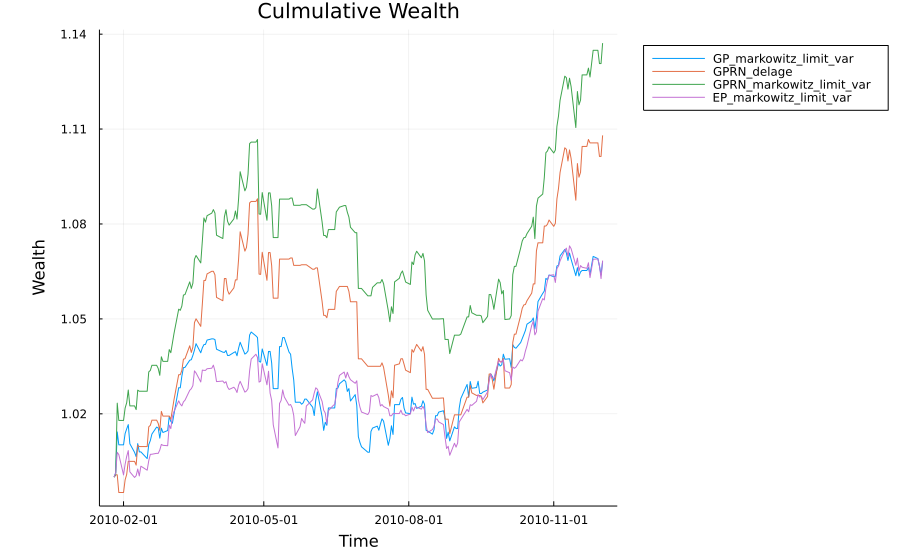

In [44]:
plt = plot(;title="Culmulative Wealth",
    xlabel="Time",
    ylabel="Wealth",
    legend=:outertopright,
    left_margin=10mm,
    size=(900, 550)
);
for (strategy_name, recorders) in backtest_results
    plot!(plt,
        axes(get_records(recorders[:wealth]), 1), get_records(recorders[:wealth]).data;
        label=strategy_name,
    )
end
plt